In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
%matplotlib inline

In [2]:
# SETUP

MU = -1
SIGMA = 1

G_INPUT_SIZE = 1
D_INPUT_SIZE = 1
D_OUTPUT_SIZE = 1
HIDDEN_SIZE_1 = 5
HIDDEN_SIZE_2 = 6

BATCH_SIZE = 200
LEARNING_RATE = 0.01
EPOCHS = 20000

In [3]:
# INIT

def z_sample(shape):
    return np.random.uniform(0, 1, shape)


def x_sample(shape):
    return np.random.normal(MU, SIGMA, shape)


def generator(z):
    hidden_1 = fully_connected(z, HIDDEN_SIZE_1, activation_fn=tf.tanh)
    hidden_2 = fully_connected(hidden_1, HIDDEN_SIZE_2, activation_fn=tf.tanh)
    output = fully_connected(hidden_2, D_INPUT_SIZE, activation_fn=tf.tanh)
    scaled_output = tf.multiply(output, 5.0)
    return scaled_output


def discriminator(x):
    hidden_1 = fully_connected(x, HIDDEN_SIZE_1, activation_fn=tf.tanh, scope='h1', reuse=True)
    hidden_2 = fully_connected(hidden_1, HIDDEN_SIZE_2, activation_fn=tf.tanh, scope='h2', reuse=True)
    output = fully_connected(hidden_2, D_OUTPUT_SIZE, activation_fn=tf.sigmoid, scope='out', reuse=True)
    return output

In [4]:
def plot_fig(session):
    # p_data
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, mlab.normpdf(xs, MU, SIGMA), label='p_data')

    # decision boundary
    r = 5000  # resolution (number of points)
    xs = np.linspace(-5, 5, r)
    ds = np.zeros((r, 1))  # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r // BATCH_SIZE):
        curr_x = np.reshape(xs[BATCH_SIZE * i:BATCH_SIZE * (i + 1)], (BATCH_SIZE, 1))
        ds[BATCH_SIZE * i:BATCH_SIZE * (i + 1)] = session.run(D1, {x: curr_x})
    
    plt.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs = np.linspace(-5, 5, r)
    gs = np.zeros((r, 1))  # generator function
    for i in range(r // BATCH_SIZE):
        curr_z = np.reshape(zs[BATCH_SIZE * i:BATCH_SIZE * (i + 1)], (BATCH_SIZE, G_INPUT_SIZE))
        gs[BATCH_SIZE * i:BATCH_SIZE * (i + 1)] = session.run(G, feed_dict={z: curr_z})
    histc, edges = np.histogram(gs, bins=20, range=(-5, 5))
    plt.plot(np.linspace(-5, 5, 20), histc / r, label='p_g')

    # ylim, legend
    plt.ylim(0, 1.1)
    plt.legend()

D params count: 6
G params count: 6
Epoch 0: loss_d=1.38694429397583 loss_g=0.706783652305603


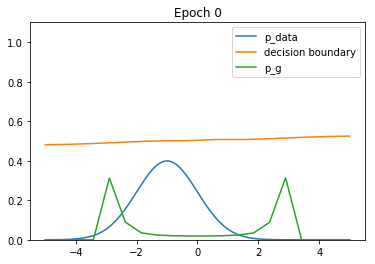

Epoch 4000: loss_d=0.7160890698432922 loss_g=0.700888991355896


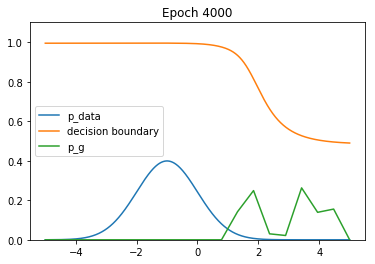

Epoch 8000: loss_d=0.7075070142745972 loss_g=0.7007049918174744


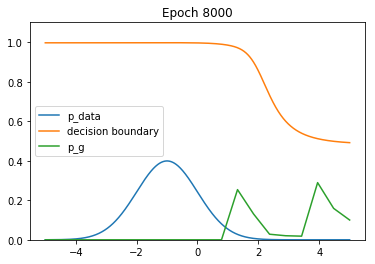

Epoch 12000: loss_d=0.7043631672859192 loss_g=0.7004334926605225


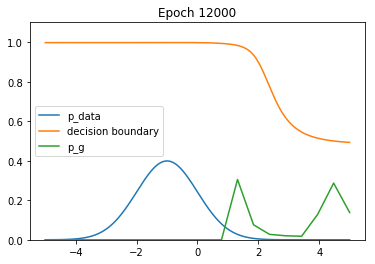

Epoch 16000: loss_d=0.7040418386459351 loss_g=0.7002391815185547


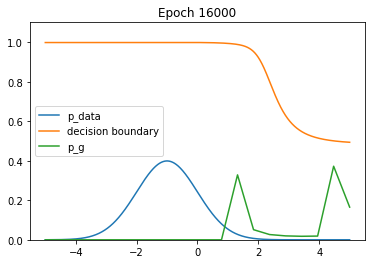

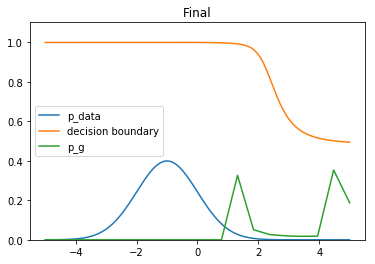

In [5]:
with tf.device('/gpu:0'):
    with tf.variable_scope('G'):
        z = tf.placeholder(tf.float32, shape=(None, G_INPUT_SIZE))
        G = generator(z)

    with tf.variable_scope('D') as scope:
        x = tf.placeholder(tf.float32, shape=(None, D_INPUT_SIZE))
        D1 = discriminator(x)
        scope.reuse_variables()
        D2 = discriminator(G)

    loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
    loss_g = tf.reduce_mean(-tf.log(D2))

    trainable_vars = tf.trainable_variables()
    d_params = [v for v in trainable_vars if v.name.startswith('D/')]
    g_params = [v for v in trainable_vars if v.name.startswith('G/')]
    print("D params count: {}".format(len(d_params)))
    print("G params count: {}".format(len(g_params)))

    opt_d = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss_d)
    opt_g = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss_g)
        
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    
    for step in range(EPOCHS):
        zs = z_sample([BATCH_SIZE, G_INPUT_SIZE])
        loss_gs, _ = session.run([loss_g, opt_g], feed_dict={z: zs})

        xs = x_sample([BATCH_SIZE, D_INPUT_SIZE])
        zs = z_sample([BATCH_SIZE, G_INPUT_SIZE])
        loss_ds, _ = session.run([loss_d, opt_d], feed_dict={x: xs, z: zs})

        if step % (EPOCHS // 5) == 0:
            print('Epoch {}: loss_d={} loss_g={}'.format(step, loss_ds, loss_gs))
            plot_fig(session)
            plt.title('Epoch {}'.format(step))
            plt.show()
            
    plot_fig(session)
    plt.title('Final')
    plt.show()